In [1]:
!gdown 1JxpQzqHm6uityY7T_VnkXX3yxkMJMgSg

Downloading...
From (original): https://drive.google.com/uc?id=1JxpQzqHm6uityY7T_VnkXX3yxkMJMgSg
From (redirected): https://drive.google.com/uc?id=1JxpQzqHm6uityY7T_VnkXX3yxkMJMgSg&confirm=t&uuid=4c066e12-b069-4b96-bdd5-2a14ac904cca
To: /content/Dataset.zip
100% 26.3M/26.3M [00:01<00:00, 22.9MB/s]


In [2]:
!unzip /content/Dataset.zip

Archive:  /content/Dataset.zip
   creating: Coronary/
   creating: Coronary/Balanced_Miscan/
  inflating: Coronary/Balanced_Miscan/d1.jpg  
  inflating: Coronary/Balanced_Miscan/d103.jpg  
  inflating: Coronary/Balanced_Miscan/d104.jpg  
  inflating: Coronary/Balanced_Miscan/d106.jpg  
  inflating: Coronary/Balanced_Miscan/d107.jpg  
  inflating: Coronary/Balanced_Miscan/d111.jpg  
  inflating: Coronary/Balanced_Miscan/d113.jpg  
  inflating: Coronary/Balanced_Miscan/d114.jpg  
  inflating: Coronary/Balanced_Miscan/d115.jpg  
  inflating: Coronary/Balanced_Miscan/d116.jpg  
  inflating: Coronary/Balanced_Miscan/d117.jpg  
  inflating: Coronary/Balanced_Miscan/d12.jpg  
  inflating: Coronary/Balanced_Miscan/d122.jpg  
  inflating: Coronary/Balanced_Miscan/d124.jpg  
  inflating: Coronary/Balanced_Miscan/d125.jpg  
  inflating: Coronary/Balanced_Miscan/d129.jpg  
  inflating: Coronary/Balanced_Miscan/d131.jpg  
  inflating: Coronary/Balanced_Miscan/d132.jpg  
  inflating: Coronary/Balanc

In [3]:
import os
import numpy as np
import pandas as pd
import joblib
from PIL import Image
import matplotlib.pyplot as plt
import glob
from pathlib import Path
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import moments_hu
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc,
    precision_recall_curve, average_precision_score, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import time
from sklearn.calibration import calibration_curve

# Function to load dataset from folder structure
def load_image_dataset(base_folder):
    """
    Load images from a base folder with class subfolders
    base_folder/
        class1/
            img1.jpg
            img2.jpg
            ...
        class2/
            img1.jpg
            img2.jpg
            ...
    """
    print(f"Loading dataset from {base_folder}...")
    images = []
    labels = []
    class_names = []

    # Get all subfolders (classes)
    class_folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]
    class_names = sorted(class_folders)

    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(base_folder, class_name)
        print(f"Processing class {class_name} from {class_path}")

        # Get all images in this class folder
        image_paths = []
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
            image_paths.extend(glob.glob(os.path.join(class_path, ext)))

        for img_path in image_paths:
            try:
                # Open image and convert to consistent format
                img = Image.open(img_path).convert('RGB')

                # Resize image to a consistent size
                img = img.resize((64, 64), Image.LANCZOS)

                # Convert to numpy array and flatten
                img_array = np.array(img)

                # Add to dataset
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)

    print(f"Dataset loaded: {X.shape[0]} images, {len(class_names)} classes")
    print(f"Image shape: {X.shape[1:]} (height, width, channels)")

    return X, y, class_names

# Feature extraction functions
def extract_color_histograms(image):
    """Extract color histograms from an RGB image"""
    hist_r = np.histogram(image[:,:,0], bins=32, range=(0,256))[0]
    hist_g = np.histogram(image[:,:,1], bins=32, range=(0,256))[0]
    hist_b = np.histogram(image[:,:,2], bins=32, range=(0,256))[0]

    # Combine histograms
    hist_features = np.concatenate([hist_r, hist_g, hist_b])

    # Add some basic statistics (mean and std for each channel)
    mean_r = np.mean(image[:,:,0])
    mean_g = np.mean(image[:,:,1])
    mean_b = np.mean(image[:,:,2])
    std_r = np.std(image[:,:,0])
    std_g = np.std(image[:,:,1])
    std_b = np.std(image[:,:,2])

    stats_features = np.array([mean_r, mean_g, mean_b, std_r, std_g, std_b])

    return np.concatenate([hist_features, stats_features])

def extract_hu_moments(image):
    """Extract Hu moments from an image"""
    gray = rgb2gray(image)
    gray = (gray * 255).astype(np.uint8)
    hu_moments = moments_hu(gray)
    return hu_moments

def extract_haralick_features(image):
    """Extract Haralick texture features from an image"""
    gray = rgb2gray(image)
    gray = (gray * 255).astype(np.uint8)

    # Calculate GLCM with different distances and angles
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Calculate Haralick properties
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    features = []

    for prop in properties:
        feature = graycoprops(glcm, prop).flatten()
        features.append(feature)

    return np.array(features).flatten()

def extract_color_texture(image):
    """Extract color texture features using LBP or similar methods"""
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Get individual channels
    h, s, v = cv2.split(hsv)

    # Apply LBP-like texture analysis on each channel
    features = []
    for channel in [h, s, v]:
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = np.mean(((channel - mean) / (std + 1e-10)) ** 3)
        kurtosis = np.mean(((channel - mean) / (std + 1e-10)) ** 4) - 3
        features.extend([mean, std, skewness, kurtosis])

    return np.array(features)

def extract_all_features(X_data):
    """Extract all features from a dataset of images"""
    print("Extracting features from images...")
    all_features = []

    for img in X_data:
        # Extract different feature types
        color_hist = extract_color_histograms(img)
        hu_moments = extract_hu_moments(img)
        haralick = extract_haralick_features(img)
        color_tex = extract_color_texture(img)

        # Combine all features
        combined = np.concatenate([color_hist, hu_moments, haralick, color_tex])
        all_features.append(combined)

    features_array = np.array(all_features)
    print(f"Features extracted: {features_array.shape[1]} features per image")
    return features_array

# New function to visualize feature importance
def plot_feature_importance(model, feature_names=None):
    """Plot feature importance for tree-based models"""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        # If feature names not provided, create generic names
        if feature_names is None:
            feature_names = [f'Feature {i}' for i in range(len(importances))]

        # Plot top 20 features
        plt.figure(figsize=(12, 8))
        plt.title('Feature Importance')
        plt.bar(range(min(20, len(indices))),
                importances[indices[:20]],
                align='center')
        plt.xticks(range(min(20, len(indices))),
                  [feature_names[i] if i < len(feature_names) else f'Feature {i}' for i in indices[:20]],
                  rotation=90)
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.close()

        return importances
    else:
        print("Model doesn't support feature importance visualization")
        return None

# New function to visualize data distribution with PCA and t-SNE
def visualize_data_distribution(X, y, class_names):
    """Visualize data distribution using PCA and t-SNE"""
    # PCA visualization
    print("Generating PCA visualization...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(12, 10))
    for i, class_name in enumerate(class_names):
        plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], alpha=0.7, label=class_name)

    plt.title('PCA Visualization of Dataset')
    plt.xlabel(f'PC1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2f})')
    plt.ylabel(f'PC2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2f})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('pca_visualization.png')
    plt.close()

    # t-SNE visualization (can be slow for large datasets)
    print("Generating t-SNE visualization (this may take a while)...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)//10))
    X_tsne = tsne.fit_transform(X)

    plt.figure(figsize=(12, 10))
    for i, class_name in enumerate(class_names):
        plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], alpha=0.7, label=class_name)

    plt.title('t-SNE Visualization of Dataset')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('tsne_visualization.png')
    plt.close()

# New function to plot learning curves
def plot_learning_curve(model, X, y, cv=5):
    """Plot learning curve to show model performance with varying training set sizes"""
    print("Generating learning curve...")
    train_sizes = np.linspace(0.1, 1.0, 10)

    # Use StratifiedKFold for classification
    cv_method = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Calculate scores for different training set sizes
    train_sizes_abs, train_scores, test_scores = [], [], []

    for train_size in train_sizes:
        size = int(train_size * len(X))
        if size < cv:  # Ensure we have at least cv samples
            continue

        # Get indices for this subset
        indices = np.random.choice(len(X), size=size, replace=False)
        X_subset, y_subset = X[indices], y[indices]

        # Calculate cross-validation scores
        cv_train_scores = []
        cv_test_scores = []

        for train_idx, test_idx in cv_method.split(X_subset, y_subset):
            X_train_cv, X_test_cv = X_subset[train_idx], X_subset[test_idx]
            y_train_cv, y_test_cv = y_subset[train_idx], y_subset[test_idx]

            model.fit(X_train_cv, y_train_cv)
            cv_train_scores.append(model.score(X_train_cv, y_train_cv))
            cv_test_scores.append(model.score(X_test_cv, y_test_cv))

        train_sizes_abs.append(size)
        train_scores.append(cv_train_scores)
        test_scores.append(cv_test_scores)

    # Convert to numpy arrays
    train_scores = np.array(train_scores)
    test_scores = np.array(test_scores)

    # Calculate mean and std
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.figure(figsize=(10, 6))
    plt.title('Learning Curve')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.fill_between(train_sizes_abs,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes_abs,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1, color="g")
    plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.savefig('learning_curve.png')
    plt.close()

# New function to plot ROC curves
def plot_roc_curves(models, X_test, y_test, class_names):
    """Plot ROC curves for all models"""
    print("Generating ROC curves...")
    plt.figure(figsize=(12, 8))

    # For binary classification
    if len(class_names) == 2:
        for name, model in models.items():
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_score)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curves')
        plt.legend(loc="lower right")

    # For multi-class classification
    else:
        # Use one-vs-rest approach
        for name, model in models.items():
            if hasattr(model, "predict_proba"):
                # Compute ROC curve and ROC area for each class
                y_score = model.predict_proba(X_test)

                # Compute micro-average ROC curve and ROC area
                fpr = dict()
                tpr = dict()
                roc_auc = dict()

                # One-vs-Rest approach
                for i in range(len(class_names)):
                    y_true_binary = (y_test == i).astype(int)
                    fpr[i], tpr[i], _ = roc_curve(y_true_binary, y_score[:, i])
                    roc_auc[i] = auc(fpr[i], tpr[i])

                # Compute micro-average ROC curve and ROC area
                y_test_bin = np.eye(len(class_names))[y_test]
                fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
                roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

                plt.plot(fpr["micro"], tpr["micro"], lw=2,
                         label=f'{name} (micro-avg AUC = {roc_auc["micro"]:.3f})')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('roc_curves.png')
    plt.close()

    # For multi-class, also plot class-specific ROC curves
    if len(class_names) > 2:
        for name, model in models.items():
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)

                # Plot ROC curves for each class
                plt.figure(figsize=(15, 10))

                for i in range(len(class_names)):
                    y_true_binary = (y_test == i).astype(int)
                    fpr, tpr, _ = roc_curve(y_true_binary, y_score[:, i])
                    roc_auc_val = auc(fpr, tpr)
                    plt.plot(fpr, tpr, lw=2,
                             label=f'Class {class_names[i]} (AUC = {roc_auc_val:.3f})')

                plt.plot([0, 1], [0, 1], 'k--', lw=2)
                plt.xlim([0.0, 1.0])
                plt.ylim([0.0, 1.05])
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curves for {name} (One-vs-Rest)')
                plt.legend(loc="lower right")
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.savefig(f'roc_curves_{name.replace(" ", "_").lower()}_per_class.png')
                plt.close()

# New function to plot precision-recall curves
def plot_precision_recall_curves(models, X_test, y_test, class_names):
    """Plot precision-recall curves for all models"""
    print("Generating precision-recall curves...")
    plt.figure(figsize=(12, 8))

    # For binary classification
    if len(class_names) == 2:
        for name, model in models.items():
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)[:, 1]
                precision, recall, _ = precision_recall_curve(y_test, y_score)
                avg_precision = average_precision_score(y_test, y_score)
                plt.plot(recall, precision, lw=2, label=f'{name} (AP = {avg_precision:.3f})')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves')
        plt.legend(loc="best")

    # For multi-class classification
    else:
        # Use one-vs-rest approach
        for name, model in models.items():
            if hasattr(model, "predict_proba"):
                # Compute precision-recall curve for each class
                y_score = model.predict_proba(X_test)

                # Compute micro-average precision-recall curve
                precision = dict()
                recall = dict()
                avg_precision = dict()

                # One-vs-Rest approach
                for i in range(len(class_names)):
                    y_true_binary = (y_test == i).astype(int)
                    precision[i], recall[i], _ = precision_recall_curve(y_true_binary, y_score[:, i])
                    avg_precision[i] = average_precision_score(y_true_binary, y_score[:, i])

                # Compute micro-average precision-recall curve
                y_test_bin = np.eye(len(class_names))[y_test]
                precision["micro"], recall["micro"], _ = precision_recall_curve(
                    y_test_bin.ravel(), y_score.ravel())
                avg_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")

                plt.plot(recall["micro"], precision["micro"], lw=2,
                         label=f'{name} (micro-avg AP = {avg_precision["micro"]:.3f})')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('precision_recall_curves.png')
    plt.close()

    # For multi-class, also plot class-specific precision-recall curves
    if len(class_names) > 2:
        for name, model in models.items():
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)

                # Plot precision-recall curves for each class
                plt.figure(figsize=(15, 10))

                for i in range(len(class_names)):
                    y_true_binary = (y_test == i).astype(int)
                    precision, recall, _ = precision_recall_curve(y_true_binary, y_score[:, i])
                    avg_precision_val = average_precision_score(y_true_binary, y_score[:, i])
                    plt.plot(recall, precision, lw=2,
                             label=f'Class {class_names[i]} (AP = {avg_precision_val:.3f})')

                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.title(f'Precision-Recall Curves for {name} (One-vs-Rest)')
                plt.legend(loc="best")
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.savefig(f'precision_recall_curves_{name.replace(" ", "_").lower()}_per_class.png')
                plt.close()

# New function to plot calibration curves
def plot_calibration_curves(models, X_test, y_test, class_names):
    """Plot calibration curves for all models"""
    print("Generating calibration curves...")
    plt.figure(figsize=(12, 8))

    # For binary classification
    if len(class_names) == 2:
        for name, model in models.items():
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test)[:, 1]
                prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
                plt.plot(prob_pred, prob_true, marker='o', linewidth=2, label=name)

        plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
        plt.xlabel('Mean predicted probability')
        plt.ylabel('Fraction of positives')
        plt.title('Calibration Curves')
        plt.legend(loc="best")

    # For multi-class, plot calibration for each class
    else:
        # Create a separate plot for each model
        for name, model in models.items():
            if hasattr(model, "predict_proba"):
                plt.figure(figsize=(15, 10))
                y_prob = model.predict_proba(X_test)

                for i in range(len(class_names)):
                    y_true_binary = (y_test == i).astype(int)
                    prob_true, prob_pred = calibration_curve(y_true_binary, y_prob[:, i], n_bins=10)
                    plt.plot(prob_pred, prob_true, marker='o', linewidth=2,
                             label=f'Class {class_names[i]}')

                plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
                plt.xlabel('Mean predicted probability')
                plt.ylabel('Fraction of positives')
                plt.title(f'Calibration Curves for {name}')
                plt.legend(loc="best")
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.savefig(f'calibration_curves_{name.replace(" ", "_").lower()}.png')
                plt.close()

    if len(class_names) == 2:
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('calibration_curves.png')
        plt.close()

# New function to create a heatmap of feature correlations
def plot_feature_correlations(X_features):
    """Plot correlation matrix of features"""
    print("Generating feature correlation heatmap...")
    # Calculate correlation matrix
    corr_matrix = np.corrcoef(X_features, rowvar=False)

    # Plot heatmap
    plt.figure(figsize=(16, 14))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
                xticklabels=False, yticklabels=False)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.savefig('feature_correlation_heatmap.png')
    plt.close()

    # If the matrix is too large, also plot a subset
    if corr_matrix.shape[0] > 50:
        # Plot top 50x50 features
        plt.figure(figsize=(16, 14))
        sns.heatmap(corr_matrix[:50, :50], cmap='coolwarm', center=0,
                    xticklabels=False, yticklabels=False)
        plt.title('Feature Correlation Matrix (Top 50x50 Features)')
        plt.tight_layout()
        plt.savefig('feature_correlation_heatmap_subset.png')
        plt.close()

# Enhanced model training and evaluation with more metrics
def train_and_evaluate_models(X_train, X_test, y_train, y_test, class_names):
    """Train and evaluate multiple models with enhanced metrics"""
    models = {}
    results = {}
    all_metrics = {}

    # Dictionary to store training times
    training_times = {}

    # Random Forest
    print("\nTraining Random Forest...")
    start_time = time.time()
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    training_times['Random Forest'] = time.time() - start_time

    # Calculate metrics
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_precision = precision_score(y_test, rf_pred, average='weighted')
    rf_recall = recall_score(y_test, rf_pred, average='weighted')
    rf_f1 = f1_score(y_test, rf_pred, average='weighted')

    # Store results
    models['Random Forest'] = rf_model
    results['Random Forest'] = rf_accuracy
    all_metrics['Random Forest'] = {
        'accuracy': rf_accuracy,
        'precision': rf_precision,
        'recall': rf_recall,
        'f1_score': rf_f1,
        'training_time': training_times['Random Forest']
    }

    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
    print(f"Random Forest Precision: {rf_precision:.4f}")
    print(f"Random Forest Recall: {rf_recall:.4f}")
    print(f"Random Forest F1 Score: {rf_f1:.4f}")
    print(f"Random Forest Training Time: {training_times['Random Forest']:.2f} seconds")

    # KNN
    print("\nTraining KNN...")
    param_grid = {'n_neighbors': range(1, 20, 2)}
    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    best_k = grid_search.best_params_['n_neighbors']
    print(f"Best K value: {best_k}")
    knn_model = KNeighborsClassifier(n_neighbors=best_k)
    knn_model.fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)
    training_times['KNN'] = time.time() - start_time

    # Calculate metrics
    knn_accuracy = accuracy_score(y_test, knn_pred)
    knn_precision = precision_score(y_test, knn_pred, average='weighted')
    knn_recall = recall_score(y_test, knn_pred, average='weighted')
    knn_f1 = f1_score(y_test, knn_pred, average='weighted')

    # Store results
    models['KNN'] = knn_model
    results['KNN'] = knn_accuracy
    all_metrics['KNN'] = {
        'accuracy': knn_accuracy,
        'precision': knn_precision,
        'recall': knn_recall,
        'f1_score': knn_f1,
        'training_time': training_times['KNN']
    }

    print(f"KNN Accuracy: {knn_accuracy:.4f}")
    print(f"KNN Precision: {knn_precision:.4f}")
    print(f"KNN Recall: {knn_recall:.4f}")
    print(f"KNN F1 Score: {knn_f1:.4f}")
    print(f"KNN Training Time: {training_times['KNN']:.2f} seconds")

    # XGBoost
    print("\nTraining XGBoost...")
    start_time = time.time()
    xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    training_times['XGBoost'] = time.time() - start_time

    # Calculate metrics
    xgb_accuracy = accuracy_score(y_test, xgb_pred)
    xgb_precision = precision_score(y_test, xgb_pred, average='weighted')
    xgb_recall = recall_score(y_test, xgb_pred, average='weighted')
    xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')

    # Store results
    models['XGBoost'] = xgb_model
    results['XGBoost'] = xgb_accuracy
    all_metrics['XGBoost'] = {
        'accuracy': xgb_accuracy,
        'precision': xgb_precision,
        'recall': xgb_recall,
        'f1_score': xgb_f1,
        'training_time': training_times['XGBoost']
    }

    print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
    print(f"XGBoost Precision: {xgb_precision:.4f}")
    print(f"XGBoost Recall: {xgb_recall:.4f}")
    print(f"XGBoost F1 Score: {xgb_f1:.4f}")
    print(f"XGBoost Training Time: {training_times['XGBoost']:.2f} seconds")

    # Naive Bayes
    print("\nTraining Naive Bayes...")
    start_time = time.time()
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    nb_pred = nb_model.predict(X_test)
    training_times['Naive Bayes'] = time.time() - start_time

    # Calculate metrics
    nb_accuracy = accuracy_score(y_test, nb_pred)
    nb_precision = precision_score(y_test, nb_pred, average='weighted')
    nb_recall = recall_score(y_test, nb_pred, average='weighted')
    nb_f1 = f1_score(y_test, nb_pred, average='weighted')

    # Store results
    models['Naive Bayes'] = nb_model
    results['Naive Bayes'] = nb_accuracy
    all_metrics['Naive Bayes'] = {
        'accuracy': nb_accuracy,
        'precision': nb_precision,
        'recall': nb_recall,
        'f1_score': nb_f1,
        'training_time': training_times['Naive Bayes']
    }

    print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
    print(f"Naive Bayes Precision: {nb_precision:.4f}")
    print(f"Naive Bayes Recall: {nb_recall:.4f}")
    print(f"Naive Bayes F1 Score: {nb_f1:.4f}")
    print(f"Naive Bayes Training Time: {training_times['Naive Bayes']:.2f} seconds")

    # Voting Classifier
    print("\nTraining Voting Classifier...")
    start_time = time.time()
    voting_clf = VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
            ('knn', KNeighborsClassifier(n_neighbors=best_k)),
            ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
            ('nb', GaussianNB())
        ],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)
    voting_pred = voting_clf.predict(X_test)
    training_times['Voting Classifier'] = time.time() - start_time

    # Calculate metrics
    voting_accuracy = accuracy_score(y_test, voting_pred)
    voting_precision = precision_score(y_test, voting_pred, average='weighted')
    voting_recall = recall_score(y_test, voting_pred, average='weighted')
    voting_f1 = f1_score(y_test, voting_pred, average='weighted')

    # Store results
    models['Voting Classifier'] = voting_clf
    results['Voting Classifier'] = voting_accuracy
    all_metrics['Voting Classifier'] = {
        'accuracy': voting_accuracy,
        'precision': voting_precision,
        'recall': voting_recall,
        'f1_score': voting_f1,
        'training_time': training_times['Voting Classifier']
    }

    print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")
    print(f"Voting Classifier Precision: {voting_precision:.4f}")
    print(f"Voting Classifier Recall: {voting_recall:.4f}")
    print(f"Voting Classifier F1 Score: {voting_f1:.4f}")
    print(f"Voting Classifier Training Time: {training_times['Voting Classifier']:.2f} seconds")

    # Print classification report for the best model
    best_model_name = max(results, key=results.get)
    best_model = models[best_model_name]
    best_pred = best_model.predict(X_test)

    print(f"\nBest Model: {best_model_name} with accuracy: {results[best_model_name]:.4f}")
    print("\nClassification Report for Best Model:")
    print(classification_report(y_test, best_pred, target_names=class_names))

    # Create confusion matrix for the best model
    cm = confusion_matrix(y_test, best_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('best_model_confusion_matrix.png')
    plt.close()

    # Plot normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Normalized Confusion Matrix - {best_model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('best_model_normalized_confusion_matrix.png')
    plt.close()

    # Plot model comparison - accuracy
    plt.figure(figsize=(12, 6))
    model_names = list(results.keys())
    accuracies = [all_metrics[model]['accuracy'] for model in model_names]

    plt.bar(model_names, accuracies, color=['blue', 'green', 'red', 'orange', 'purple'])
    plt.title('Model Comparison - Accuracy')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.0)
    plt.xticks(rotation=45)

    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center')

    plt.tight_layout()
    plt.savefig('model_comparison_accuracy.png')
    plt.close()

    # Plot model comparison - all metrics
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1_score']
    plt.figure(figsize=(15, 10))

    x = np.arange(len(model_names))
    width = 0.2
    multiplier = 0

    for metric in metrics_to_plot:
        metric_values = [all_metrics[model][metric] for model in model_names]
        offset = width * multiplier
        rects = plt.bar(x + offset, metric_values, width, label=metric.capitalize())
        plt.bar_label(rects, fmt='%.2f', padding=3, fontsize=8)
        multiplier += 1

    plt.title('Model Comparison - Multiple Metrics')
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.ylim(0, 1.1)
    plt.xticks(x + width * (len(metrics_to_plot) - 1) / 2, model_names, rotation=45)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('model_comparison_all_metrics.png')
    plt.close()

    # Plot training time comparison
    plt.figure(figsize=(12, 6))
    times = [all_metrics[model]['training_time'] for model in model_names]

    plt.bar(model_names, times, color=['blue', 'green', 'red', 'orange', 'purple'])
    plt.title('Model Comparison - Training Time')
    plt.xlabel('Model')
    plt.ylabel('Training Time (seconds)')
    plt.xticks(rotation=45)

    for i, v in enumerate(times):
        plt.text(i, v + 0.02, f'{v:.2f}s', ha='center')

    plt.tight_layout()
    plt.savefig('model_comparison_training_time.png')
    plt.close()

    # Generate additional visualizations
    # ROC curves
    plot_roc_curves(models, X_test, y_test, class_names)

    # Precision-Recall curves
    plot_precision_recall_curves(models, X_test, y_test, class_names)

    # Calibration curves
    plot_calibration_curves(models, X_test, y_test, class_names)

    # Feature importance for tree-based models
    if 'Random Forest' in models:
        plot_feature_importance(models['Random Forest'])

    if 'XGBoost' in models:
        plot_feature_importance(models['XGBoost'])

    return models, best_model_name, all_metrics

# Main function to run the image classification pipeline
def run_image_classification(base_folder):
    # Load dataset
    X, y, class_names = load_image_dataset(base_folder)

    # Extract features
    X_features = extract_all_features(X)

    # Visualize feature correlations
    plot_feature_correlations(X_features)

    # Visualize data distribution
    # Use a sample if dataset is large
    if len(X_features) > 1000:
        sample_indices = np.random.choice(len(X_features), size=1000, replace=False)
        visualize_data_distribution(X_features[sample_indices], y[sample_indices], class_names)
    else:
        visualize_data_distribution(X_features, y, class_names)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape[0]} images")
    print(f"Testing set: {X_test.shape[0]} images")

    # Normalize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate models
    models, best_model_name, all_metrics = train_and_evaluate_models(
        X_train_scaled, X_test_scaled, y_train, y_test, class_names
    )

    # Generate learning curve for best model
    best_model = models[best_model_name]
    plot_learning_curve(best_model, X_train_scaled, y_train)

    # Calculate cross-validation scores for best model
    print(f"\nPerforming cross-validation for {best_model_name}...")
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {np.mean(cv_scores):.4f} (±{np.std(cv_scores):.4f})")

    # Save the best model
    joblib.dump(best_model, f'{best_model_name.replace(" ", "_").lower()}_model.pkl')
    joblib.dump(scaler, 'feature_scaler.pkl')
    joblib.dump(class_names, 'class_names.pkl')

    print(f"\nBest model ({best_model_name}) saved.")

    # Save all models
    for model_name, model in models.items():
        joblib.dump(model, f'{model_name.replace(" ", "_").lower()}_model.pkl')

    print("All models saved.")

    # Save metrics to CSV
    metrics_df = pd.DataFrame(all_metrics).T
    metrics_df.to_csv('model_metrics.csv')
    print("Model metrics saved to model_metrics.csv")

    return models, scaler, class_names, all_metrics

# Function to make predictions on new images
def predict_image(model, scaler, class_names, image_path):
    """Predict the class of a single image"""
    try:
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')
        img = img.resize((64, 64), Image.LANCZOS)
        img_array = np.array(img)

        # Extract features
        img_reshaped = np.expand_dims(img_array, axis=0)
        features = extract_all_features(img_reshaped)

        # Scale features
        features_scaled = scaler.transform(features)

        # Predict
        prediction = model.predict(features_scaled)[0]

        # Get class name
        class_name = class_names[prediction]

        # Try to get probabilities if the model supports it
        try:
            probabilities = model.predict_proba(features_scaled)[0]
            confidence = probabilities[prediction]

            # Plot prediction confidence
            plt.figure(figsize=(10, 6))
            plt.bar(range(len(probabilities)), probabilities)
            plt.xticks(range(len(probabilities)), class_names, rotation=45)
            plt.xlabel('Class')
            plt.ylabel('Probability')
            plt.title(f'Prediction: {class_name} (Confidence: {confidence:.4f})')
            plt.tight_layout()
            plt.savefig('prediction_confidence.png')
            plt.close()

            return class_name, confidence
        except:
            return class_name, None
    except Exception as e:
        return f"Error: {e}", None

# Main execution
if __name__ == "__main__":
    # Replace this with your dataset path
    base_folder = "/content/Coronary/"

    # Run the image classification pipeline
    models, feature_scaler, classes, metrics = run_image_classification(base_folder)

    # Print summary of results
    print("\n=== SUMMARY OF RESULTS ===")
    print(f"Number of classes: {len(classes)}")
    print(f"Class names: {classes}")

    # Get best model based on accuracy
    best_model_name = max(metrics, key=lambda x: metrics[x]['accuracy'])
    print(f"\nBest model by accuracy: {best_model_name}")
    print(f"Accuracy: {metrics[best_model_name]['accuracy']:.4f}")
    print(f"Precision: {metrics[best_model_name]['precision']:.4f}")
    print(f"Recall: {metrics[best_model_name]['recall']:.4f}")
    print(f"F1 Score: {metrics[best_model_name]['f1_score']:.4f}")

    # Get best model based on F1 score
    best_f1_model = max(metrics, key=lambda x: metrics[x]['f1_score'])
    if best_f1_model != best_model_name:
        print(f"\nBest model by F1 score: {best_f1_model}")
        print(f"F1 Score: {metrics[best_f1_model]['f1_score']:.4f}")


Loading dataset from /content/Coronary/...
Processing class Balanced_Miscan from /content/Coronary/Balanced_Miscan
Processing class Balanced_Non_miscan from /content/Coronary/Balanced_Non_miscan
Dataset loaded: 967 images, 2 classes
Image shape: (64, 64, 3) (height, width, channels)
Extracting features from images...
Features extracted: 181 features per image
Generating feature correlation heatmap...
Generating PCA visualization...
Generating t-SNE visualization (this may take a while)...
Training set: 773 images
Testing set: 194 images

Training Random Forest...
Random Forest Accuracy: 0.9175
Random Forest Precision: 0.9179
Random Forest Recall: 0.9175
Random Forest F1 Score: 0.9158
Random Forest Training Time: 0.62 seconds

Training KNN...
Best K value: 1
KNN Accuracy: 0.9278
KNN Precision: 0.9287
KNN Recall: 0.9278
KNN F1 Score: 0.9281
KNN Training Time: 2.62 seconds

Training XGBoost...
XGBoost Accuracy: 0.9433
XGBoost Precision: 0.9434
XGBoost Recall: 0.9433
XGBoost F1 Score: 0.94

Loading model files...
Model loaded successfully
Available classes: ['Balanced_Miscan', 'Balanced_Non_miscan']

Please upload an image to classify...


Saving Miscana4_original_Miscana4_original_d1.jpg_5a5b7558-295f-4bbb-9c92-6b753670c56d.jpg_7f2f2c08-a4f9-4fb8-ab9e-1a879878d970.jpg to Miscana4_original_Miscana4_original_d1.jpg_5a5b7558-295f-4bbb-9c92-6b753670c56d.jpg_7f2f2c08-a4f9-4fb8-ab9e-1a879878d970.jpg


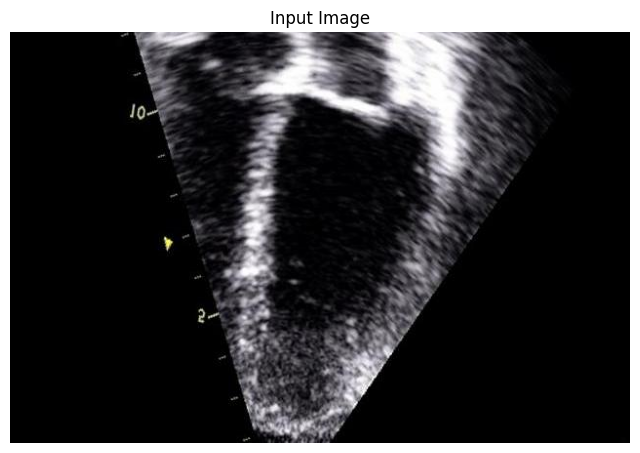

Extracting features from images...
Features extracted: 181 features per image

Predicted class: Balanced_Miscan
Confidence: 0.7446


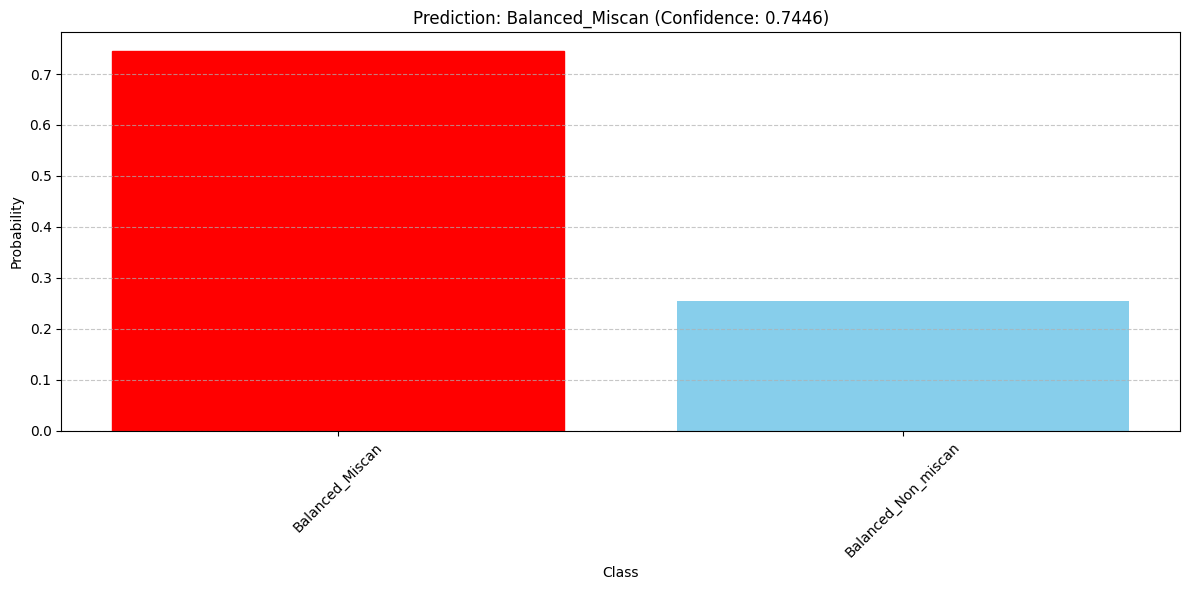

In [5]:
import os
import numpy as np
import joblib
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import moments_hu
from skimage.color import rgb2gray
from google.colab import files

# Feature extraction functions
def extract_color_histograms(image):
    """Extract color histograms from an RGB image"""
    hist_r = np.histogram(image[:,:,0], bins=32, range=(0,256))[0]
    hist_g = np.histogram(image[:,:,1], bins=32, range=(0,256))[0]
    hist_b = np.histogram(image[:,:,2], bins=32, range=(0,256))[0]

    # Combine histograms
    hist_features = np.concatenate([hist_r, hist_g, hist_b])

    # Add some basic statistics (mean and std for each channel)
    mean_r = np.mean(image[:,:,0])
    mean_g = np.mean(image[:,:,1])
    mean_b = np.mean(image[:,:,2])
    std_r = np.std(image[:,:,0])
    std_g = np.std(image[:,:,1])
    std_b = np.std(image[:,:,2])

    stats_features = np.array([mean_r, mean_g, mean_b, std_r, std_g, std_b])

    return np.concatenate([hist_features, stats_features])

def extract_hu_moments(image):
    """Extract Hu moments from an image"""
    gray = rgb2gray(image)
    gray = (gray * 255).astype(np.uint8)
    hu_moments = moments_hu(gray)
    return hu_moments

def extract_haralick_features(image):
    """Extract Haralick texture features from an image"""
    gray = rgb2gray(image)
    gray = (gray * 255).astype(np.uint8)

    # Calculate GLCM with different distances and angles
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Calculate Haralick properties
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    features = []

    for prop in properties:
        feature = graycoprops(glcm, prop).flatten()
        features.append(feature)

    return np.array(features).flatten()

def extract_color_texture(image):
    """Extract color texture features using LBP or similar methods"""
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Get individual channels
    h, s, v = cv2.split(hsv)

    # Apply LBP-like texture analysis on each channel
    features = []
    for channel in [h, s, v]:
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = np.mean(((channel - mean) / (std + 1e-10)) ** 3)
        kurtosis = np.mean(((channel - mean) / (std + 1e-10)) ** 4) - 3
        features.extend([mean, std, skewness, kurtosis])

    return np.array(features)

def extract_all_features(X_data):
    """Extract all features from a dataset of images"""
    print("Extracting features from images...")
    all_features = []

    for img in X_data:
        # Extract different feature types
        color_hist = extract_color_histograms(img)
        hu_moments = extract_hu_moments(img)
        haralick = extract_haralick_features(img)
        color_tex = extract_color_texture(img)

        # Combine all features
        combined = np.concatenate([color_hist, hu_moments, haralick, color_tex])
        all_features.append(combined)

    features_array = np.array(all_features)
    print(f"Features extracted: {features_array.shape[1]} features per image")
    return features_array

# Load the trained model
print("Loading model files...")
model = joblib.load('voting_classifier_model.pkl')  # or your best model
scaler = joblib.load('feature_scaler.pkl')
class_names = joblib.load('class_names.pkl')

print(f"Model loaded successfully")
print(f"Available classes: {class_names}")

# Function to predict a single image
def predict_image(image_path):
    """Predict the class of a single image"""
    try:
        # Load and display the image
        img = Image.open(image_path).convert('RGB')
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        plt.show()

        # Resize image to match training data
        img_resized = img.resize((64, 64), Image.LANCZOS)
        img_array = np.array(img_resized)

        # Extract features
        img_reshaped = np.expand_dims(img_array, axis=0)
        features = extract_all_features(img_reshaped)

        # Scale features
        features_scaled = scaler.transform(features)

        # Predict
        prediction = model.predict(features_scaled)[0]
        predicted_class = class_names[prediction]

        print(f"\nPredicted class: {predicted_class}")

        # Get probabilities if available
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(features_scaled)[0]
            confidence = probabilities[prediction]
            print(f"Confidence: {confidence:.4f}")

            # Plot prediction probabilities
            plt.figure(figsize=(12, 6))
            bars = plt.bar(range(len(probabilities)), probabilities, color='skyblue')
            bars[prediction].set_color('red')  # Highlight the predicted class
            plt.xticks(range(len(probabilities)), class_names, rotation=45)
            plt.xlabel('Class')
            plt.ylabel('Probability')
            plt.title(f'Prediction: {predicted_class} (Confidence: {confidence:.4f})')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

            return predicted_class, confidence

        return predicted_class, None

    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, None

# Upload and predict
print("\nPlease upload an image to classify...")
uploaded = files.upload()

if uploaded:
    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]
    predict_image(image_path)
else:
    print("No file uploaded.")

Loading model files...
Model loaded successfully
Available classes: ['Balanced_Miscan', 'Balanced_Non_miscan']

Please upload an image to classify...


Saving d2.jpg to d2.jpg


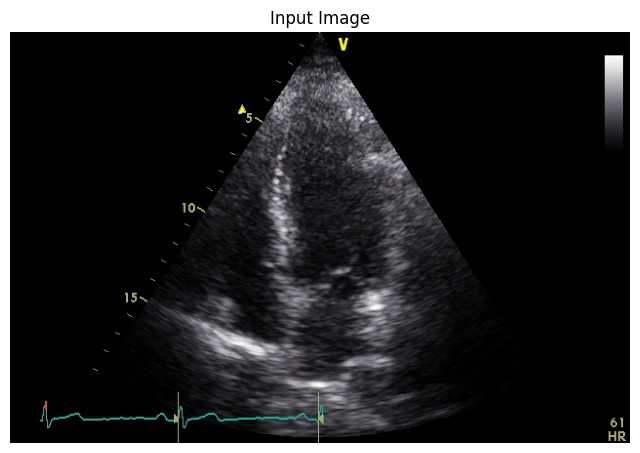

Extracting features from images...
Features extracted: 181 features per image

Predicted class: Balanced_Non_miscan
Confidence: 0.7054


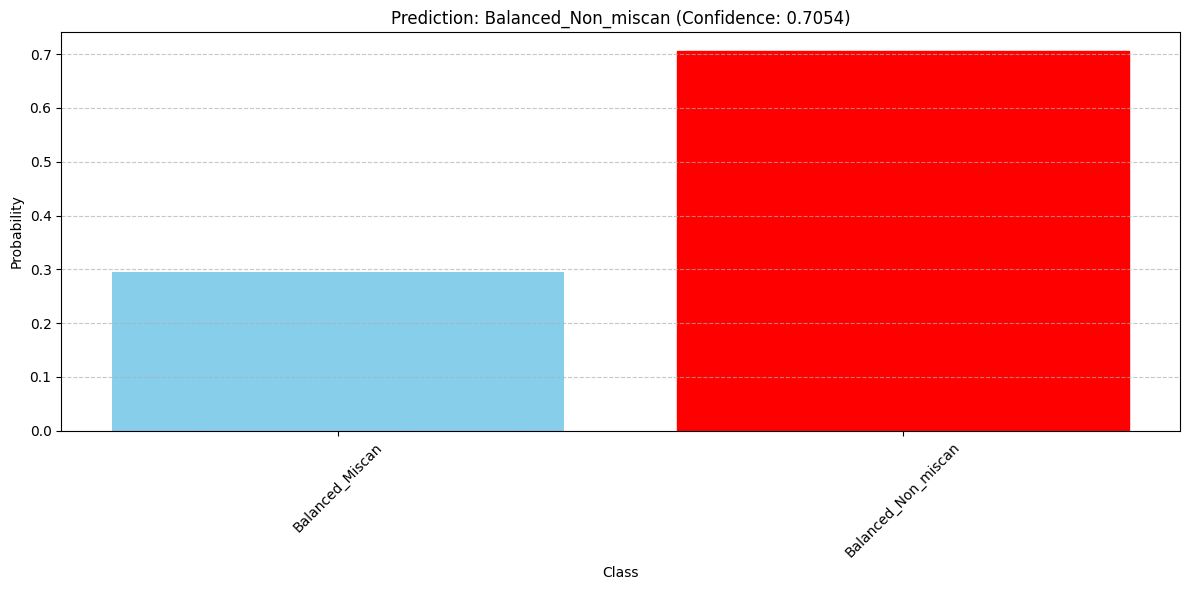

In [6]:
import os
import numpy as np
import joblib
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import moments_hu
from skimage.color import rgb2gray
from google.colab import files

# Feature extraction functions
def extract_color_histograms(image):
    """Extract color histograms from an RGB image"""
    hist_r = np.histogram(image[:,:,0], bins=32, range=(0,256))[0]
    hist_g = np.histogram(image[:,:,1], bins=32, range=(0,256))[0]
    hist_b = np.histogram(image[:,:,2], bins=32, range=(0,256))[0]

    # Combine histograms
    hist_features = np.concatenate([hist_r, hist_g, hist_b])

    # Add some basic statistics (mean and std for each channel)
    mean_r = np.mean(image[:,:,0])
    mean_g = np.mean(image[:,:,1])
    mean_b = np.mean(image[:,:,2])
    std_r = np.std(image[:,:,0])
    std_g = np.std(image[:,:,1])
    std_b = np.std(image[:,:,2])

    stats_features = np.array([mean_r, mean_g, mean_b, std_r, std_g, std_b])

    return np.concatenate([hist_features, stats_features])

def extract_hu_moments(image):
    """Extract Hu moments from an image"""
    gray = rgb2gray(image)
    gray = (gray * 255).astype(np.uint8)
    hu_moments = moments_hu(gray)
    return hu_moments

def extract_haralick_features(image):
    """Extract Haralick texture features from an image"""
    gray = rgb2gray(image)
    gray = (gray * 255).astype(np.uint8)

    # Calculate GLCM with different distances and angles
    distances = [1, 2, 3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Calculate Haralick properties
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    features = []

    for prop in properties:
        feature = graycoprops(glcm, prop).flatten()
        features.append(feature)

    return np.array(features).flatten()

def extract_color_texture(image):
    """Extract color texture features using LBP or similar methods"""
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Get individual channels
    h, s, v = cv2.split(hsv)

    # Apply LBP-like texture analysis on each channel
    features = []
    for channel in [h, s, v]:
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = np.mean(((channel - mean) / (std + 1e-10)) ** 3)
        kurtosis = np.mean(((channel - mean) / (std + 1e-10)) ** 4) - 3
        features.extend([mean, std, skewness, kurtosis])

    return np.array(features)

def extract_all_features(X_data):
    """Extract all features from a dataset of images"""
    print("Extracting features from images...")
    all_features = []

    for img in X_data:
        # Extract different feature types
        color_hist = extract_color_histograms(img)
        hu_moments = extract_hu_moments(img)
        haralick = extract_haralick_features(img)
        color_tex = extract_color_texture(img)

        # Combine all features
        combined = np.concatenate([color_hist, hu_moments, haralick, color_tex])
        all_features.append(combined)

    features_array = np.array(all_features)
    print(f"Features extracted: {features_array.shape[1]} features per image")
    return features_array

# Load the trained model
print("Loading model files...")
model = joblib.load('voting_classifier_model.pkl')  # or your best model
scaler = joblib.load('feature_scaler.pkl')
class_names = joblib.load('class_names.pkl')

print(f"Model loaded successfully")
print(f"Available classes: {class_names}")

# Function to predict a single image
def predict_image(image_path):
    """Predict the class of a single image"""
    try:
        # Load and display the image
        img = Image.open(image_path).convert('RGB')
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.title("Input Image")
        plt.axis('off')
        plt.show()

        # Resize image to match training data
        img_resized = img.resize((64, 64), Image.LANCZOS)
        img_array = np.array(img_resized)

        # Extract features
        img_reshaped = np.expand_dims(img_array, axis=0)
        features = extract_all_features(img_reshaped)

        # Scale features
        features_scaled = scaler.transform(features)

        # Predict
        prediction = model.predict(features_scaled)[0]
        predicted_class = class_names[prediction]

        print(f"\nPredicted class: {predicted_class}")

        # Get probabilities if available
        if hasattr(model, 'predict_proba'):
            probabilities = model.predict_proba(features_scaled)[0]
            confidence = probabilities[prediction]
            print(f"Confidence: {confidence:.4f}")

            # Plot prediction probabilities
            plt.figure(figsize=(12, 6))
            bars = plt.bar(range(len(probabilities)), probabilities, color='skyblue')
            bars[prediction].set_color('red')  # Highlight the predicted class
            plt.xticks(range(len(probabilities)), class_names, rotation=45)
            plt.xlabel('Class')
            plt.ylabel('Probability')
            plt.title(f'Prediction: {predicted_class} (Confidence: {confidence:.4f})')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()

            return predicted_class, confidence

        return predicted_class, None

    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, None

# Upload and predict
print("\nPlease upload an image to classify...")
uploaded = files.upload()

if uploaded:
    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]
    predict_image(image_path)
else:
    print("No file uploaded.")